In [1]:
from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from environments import ARESEAOptimization
from environments.onestep import ARESEAOneStep
# from onestep import GaussianActor, Simulation

## Bayesian Optimisation

In [3]:
env = ARESEAOneStep()
observation = env.reset()
before = env.segment.AREABSCR1.reading

In [4]:
def objective_fn(q1, q2, q3, cv, ch):
    action = np.array([q1, q2, q3, cv, ch])
    _, reward, _, _ = env.step(action)
    return reward

In [5]:
pbounds = {"q1": (-1,1), "q2": (-1,1), "q3": (-1,1), "cv": (-1,1), "ch": (-1,1)}

In [6]:
optimizer = BayesianOptimization(
    f=objective_fn,
    pbounds=pbounds
)
optimizer.maximize(init_points=3, n_iter=50-3)

|   iter    |  target   |    ch     |    cv     |    q1     |    q2     |    q3     |
-------------------------------------------------------------------------------------
|  1        |  3.48     |  0.1944   |  0.6644   |  0.6272   | -0.1405   | -0.5578   |
|  2        |  3.34     |  0.1018   | -0.1355   | -0.9795   |  0.6377   |  0.05163  |
|  3        |  4.235    |  0.3965   |  0.9689   | -0.1142   | -0.602    |  0.5364   |
|  4        |  3.215    |  0.9612   | -0.04418  |  0.5283   |  0.3939   | -0.1742   |
|  5        |  4.016    |  0.3958   |  1.0      | -0.2347   | -0.7787   |  0.7487   |
|  6        |  4.146    |  0.04696  |  1.0      |  0.1548   | -0.2525   |  0.7093   |
|  7        |  3.086    | -0.2599   |  1.0      | -0.2641   | -0.7264   |  0.1141   |
|  8        |  4.159    | -0.1913   |  0.1169   | -0.4852   | -0.2777   |  0.7111   |
|  9        |  4.009    | -0.1207   |  0.1218   | -0.5859   | -0.08696  |  0.6194   |
|  10       |  4.493    | -0.03098  |  0.7655   |  0.3

Desired: [-1.0753864e-03  4.0668494e-04  3.8527991e-04  4.1046551e-05]
Objective: 6.984092769362968


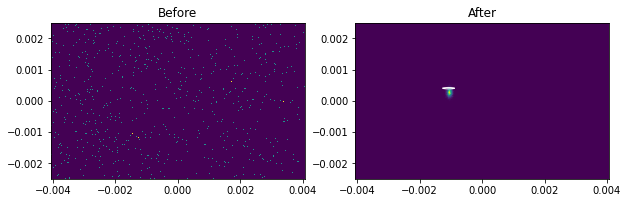

In [7]:
print("Desired:", env.desired)

screen = env.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

_, reward, _, _ = env.step(np.array([
    optimizer.max["params"]["q1"],
    optimizer.max["params"]["q2"],
    optimizer.max["params"]["q3"],
    optimizer.max["params"]["cv"],
    optimizer.max["params"]["ch"]
]))
print("Objective:", reward)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

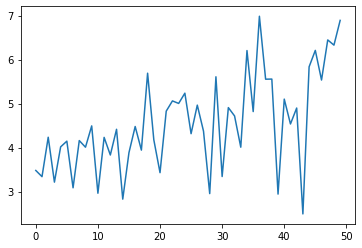

In [8]:
plt.plot(optimizer.space.target)
plt.show()

In [9]:
simulation = Simulation()
simulation.reset(incoming=env.incoming, initial_actuators=env.initial_actuators, desired=env.desired)

array([-1.84034233e+01, -1.21940193e+01,  7.34188223e+00,  2.52218242e-03,
       -4.58480138e-03, -1.07538642e-03,  4.06684936e-04,  3.85279913e-04,
        4.10465509e-05, -1.20992605e-02,  1.93577178e-03,  1.15666501e-02,
        5.50798094e-03])

In [10]:
def target_fn(q1, q2, q3, cv, ch):
    normalized_actuators = np.array([q1, q2, q3, cv, ch])
    actuators = normalized_actuators * simulation.actuator_space.high
    
    achieved = simulation.track(actuators)
    
    def objective_fn(achieved, desired):
        offset = achieved - desired
        weights = np.array([1, 1, 2, 2])

        return -np.log((weights * np.abs(offset)).sum())
    
    return objective_fn(achieved, simulation.desired)

In [11]:
pbounds = {"q1": (-1,1), "q2": (-1,1), "q3": (-1,1), "cv": (-1,1), "ch": (-1,1)}

In [12]:
optimizer = BayesianOptimization(
    f=target_fn,
    pbounds=pbounds,
    bounds_transformer=SequentialDomainReductionTransformer()
)
optimizer.maximize(init_points=3, n_iter=50-3)

|   iter    |  target   |    ch     |    cv     |    q1     |    q2     |    q3     |
-------------------------------------------------------------------------------------
|  1        |  3.76     |  0.9457   |  0.4154   |  0.4671   | -0.9488   |  0.2071   |
|  2        |  1.971    |  0.9904   |  0.3741   |  0.7735   |  0.9005   |  0.7491   |
|  3        |  4.208    | -0.1578   | -0.9042   |  0.2209   | -0.6671   |  0.9839   |
|  4        |  3.707    | -0.1884   | -0.6466   | -0.3845   | -0.4793   |  0.4924   |
|  5        |  3.435    | -0.6641   | -0.3882   |  0.7833   | -1.0      |  0.5789   |
|  6        |  3.557    |  0.2979   | -1.0      |  0.4721   | -1.0      |  0.4907   |
|  7        |  3.292    | -0.5679   | -1.0      | -0.2346   | -1.0      |  1.0      |
|  8        |  4.029    | -0.1642   | -0.864    |  0.1929   | -0.7198   |  0.9689   |
|  9        |  3.808    |  0.02935  | -1.0      |  0.3432   | -0.3107   |  0.999    |
|  10       |  4.482    | -0.4006   | -1.0      |  0.5

Desired: [-1.0753864e-03  4.0668494e-04  3.8527991e-04  4.1046551e-05]
Objective: 5.065753627870985


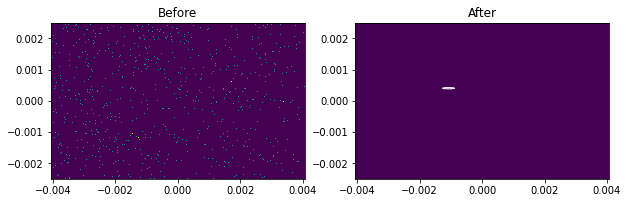

In [13]:
print("Desired:", env.desired)

screen = simulation.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

objective = target_fn(**optimizer.max["params"])

print("Objective:", objective)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

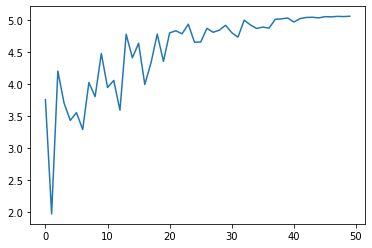

In [14]:
plt.plot(optimizer.space.target)
plt.show()

In [20]:
simulation = Simulation()
simulation.reset(incoming=env.incoming, initial_actuators=env.initial_actuators, desired=env.desired)

array([ 2.67627354e+01, -1.44128389e+01, -2.61807842e+01,  9.63873463e-04,
       -2.74340913e-04, -1.21624023e-03,  2.51503458e-04,  1.27762993e-04,
        6.96546776e-05, -3.28234062e-02, -2.27606666e-04,  5.09303762e-03,
        5.83616411e-03])

In [21]:
optimizer = BayesianOptimization(
    f=target_fn,
    pbounds=pbounds
)
optimizer.maximize(init_points=3, n_iter=50-3)

|   iter    |  target   |    ch     |    cv     |    q1     |    q2     |    q3     |
-------------------------------------------------------------------------------------
|  1        |  4.578    | -0.9923   |  0.9271   | -0.442    |  0.372    |  0.2167   |
|  2        |  2.45     | -0.8789   | -0.5688   |  0.7641   |  0.6913   |  0.3891   |
|  3        |  4.421    |  0.8394   |  0.5077   |  0.02866  |  0.08225  | -0.7084   |
|  4        |  4.666    |  0.755    |  0.5298   |  0.0294   |  0.1394   | -0.6638   |
|  5        |  5.08     |  0.1286   |  0.7675   | -0.1416   |  0.3346   | -0.3559   |
|  6        |  3.901    |  0.4991   |  1.0      |  0.2707   |  1.0      | -0.6147   |
|  7        |  3.796    |  0.3611   |  0.3062   | -0.5387   |  0.1373   | -0.09786  |
|  8        |  5.501    |  0.1404   |  0.7824   |  0.202    |  0.03035  | -0.6442   |
|  9        |  3.615    | -0.2204   |  1.0      | -0.1881   |  0.006194 | -0.9985   |
|  10       |  4.34     |  0.2828   |  0.7261   |  0.3

Desired: [-1.2162402e-03  2.5150346e-04  1.2776299e-04  6.9654678e-05]
Objective: 5.556186841719153


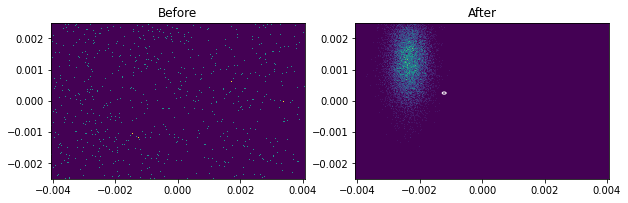

In [23]:
print("Desired:", env.desired)

screen = simulation.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

objective = target_fn(**optimizer.max["params"])

print("Objective:", objective)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

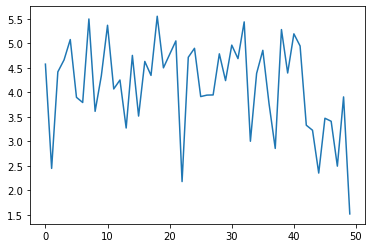

In [22]:
plt.plot(optimizer.space.target)
plt.show()

## Reinforcement Learning

In [15]:
timestamp = "20210908093749"
model = torch.load(f"models/onestep_vpg/onestep-model-{timestamp}.pkl")

Objective: 6.7054574443329775


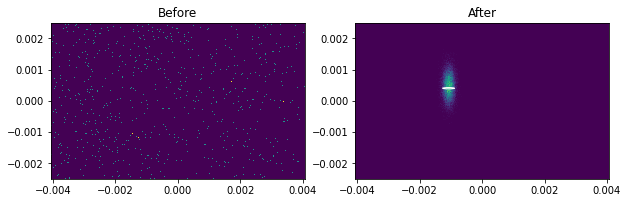

In [16]:
screen = env.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

torched_observation = torch.tensor(observation, dtype=torch.float32)
unsqueezed_observation = torched_observation.unsqueeze(0)
unsqueezed_actuators = model(unsqueezed_observation).sample()
torched_actuators = unsqueezed_actuators.squeeze()
actuators = torched_actuators.detach().numpy()
_, reward, _, _ = env.step(actuators)

print("Objective:", reward)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

In [17]:
simulation = Simulation()
simulation.reset(incoming=env.incoming, initial_actuators=env.initial_actuators, desired=env.desired)

array([-1.84034233e+01, -1.21940193e+01,  7.34188223e+00,  2.52218242e-03,
       -4.58480138e-03, -1.07538642e-03,  4.06684936e-04,  3.85279913e-04,
        4.10465509e-05, -1.20992605e-02,  1.93577178e-03,  1.15666501e-02,
        5.50798094e-03])

Objective: 6.7054574443329775


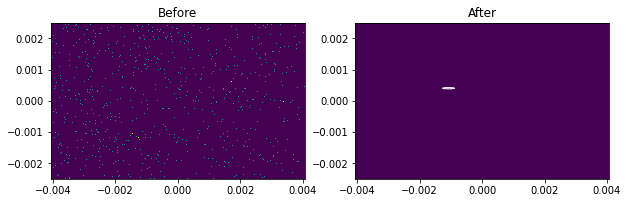

In [18]:
screen = simulation.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

observation_factor = np.concatenate([
    simulation.actuator_space.high,
    simulation.goal_space.high,
    simulation.goal_space.high
])

normalized_observation = observation / observation_factor
normalized_observation = torch.tensor(normalized_observation, dtype=torch.float32)
unsqueezed_observation = normalized_observation.unsqueeze(0)

unsqueezed_actuators = model(unsqueezed_observation).sample()

normalized_actuators = unsqueezed_actuators.squeeze()
actuators = normalized_actuators.detach().numpy() * simulation.actuator_space.high

simulation.track(actuators)

print("Objective:", reward)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = simulation.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

## Bla bla

In [19]:
simulation = Simulation()
sobservation = simulation.reset()

env = ARESEAOneStep()
eobservation = env.reset(
    incoming=simulation.incoming,
    initial_actuators=simulation.initial_actuators,
    desired=simulation.desired
)

print("Simulation:", sobservation)
print("Environment:", eobservation)

Simulation: [ 2.67627354e+01 -1.44128389e+01 -2.61807842e+01  9.63873463e-04
 -2.74340913e-04 -1.21624023e-03  2.51503458e-04  1.27762993e-04
  6.96546776e-05 -3.28234062e-02 -2.27606666e-04  5.09303762e-03
  5.83616411e-03]
Environment: [  0.89209118  -0.48042796  -0.87269281   0.32129115  -0.04572349
  -0.60812008   0.12575172   0.25552597   0.13930935 -16.4117023
  -0.11380333  10.18607475  11.67232767]


## Run evaluation on fixed problem set

In [2]:
def pack_dataframe(fn):
    def wrapper(env, problem=None):
        observations, incoming, misalignments = fn(env, problem=problem)
        observations = np.array(observations)

        df = pd.DataFrame(np.arange(len(observations)), columns=["step"])
        df["q1"] = observations[:,0]
        df["q2"] = observations[:,1]
        df["q3"] = observations[:,2]
        df["cv"] = observations[:,3]
        df["ch"] = observations[:,4]
        df["mup_x"] = observations[:,5]
        df["mup_y"] = observations[:,6]
        df["sigmap_x"] = observations[:,7]
        df["sigmap_y"] = observations[:,8]
        df["mu_x"] = observations[:,9]
        df["mu_y"] = observations[:,10]
        df["sigma_x"] = observations[:,11]
        df["sigma_y"] = observations[:,12]
        for k in incoming.keys():
            df["incoming_"+k] = float(incoming[k])
        df["misalignment_q1"] = misalignments[0]
        df["misalignment_q2"] = misalignments[1]
        df["misalignment_q3"] = misalignments[2]
        df["misalignment_screen"] = misalignments[4]

        return df
    
    return wrapper

In [11]:
@pack_dataframe
def run(env, problem=None):
    if problem is not None:
        if "initial" in problem:
            env.next_initial = problem["initial"]
        if "incoming" in problem:
            env.backend.next_incoming = problem["incoming"]
        if "misalignments" in problem:
            env.backend.next_misalignments = problem["misalignments"]
        if "desired" in problem:
            env.next_desired = problem["desired"]

    observations = []

    observation = env.reset()

    observations.append(observation)
    incoming = env.backend._incoming.parameters
    misalignments = env.backend.misalignments

    def target_fn(q1, q2, q3, cv, ch):
        actuators = np.array([q1,q2,q3,cv,ch])
        observation, objective, _, _ = env.step(actuators)
        observations.append(observation)
        return -objective

    pbounds = {
        "q1": (env.action_space.low[0], env.action_space.high[0]),
        "q2": (env.action_space.low[1], env.action_space.high[1]),
        "q3": (env.action_space.low[2], env.action_space.high[2]),
        "cv": (env.action_space.low[3], env.action_space.high[3]),
        "ch": (env.action_space.low[4], env.action_space.high[4])
    }

    optimizer = BayesianOptimization(
        f=target_fn,
        pbounds=pbounds,
        verbose=0
    )
    optimizer.maximize(init_points=3, n_iter=100-3)

    return observations, incoming, misalignments

In [12]:
def cache_to_file(fn):
    def wrapper(method, **kwargs):
        filename = f".cache_3/{method}.pkl"
        
        try:
            evaluation = pd.read_pickle(filename)
            print(f"Read {method} from cache file")
        except FileNotFoundError:
            evaluation = fn(method, **kwargs)
            evaluation.to_pickle(filename)
        
        return evaluation

    return wrapper

In [13]:
@cache_to_file
def evaluate(method, description=None):
    env = ARESEAOptimization()

    with open("problems_3.json", "r") as f:
        problems = json.load(f)

    evaluation = []
    for i, problem in enumerate(tqdm(problems)):
        result = run(env, problem=problem)
        result["problem"] = i
        evaluation.append(result)
    evaluation = pd.concat(evaluation)
    evaluation["method"] = method
    evaluation["model"] = method
    if description is not None:
        evaluation["description"] = description
    
    return evaluation

In [14]:
optimization_evaluation = pd.concat([
    evaluate("bayesian-100", description="Bayesian Optimisation with 100 Steps"),
    # evaluate("nelder-mead-fdf-normalize", description="Nelder-Mead With Normalised Action")
])

100%|██████████| 300/300 [54:17<00:00, 10.86s/it]
